In [6]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import psycopg2
import shap
import joblib
from lightgbm import LGBMClassifier
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.saving import save_model
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Fetching filtered data from PostgreSQL:
def fetch_data_from_db():
    DB_HOST = "localhost"
    DB_PORT = "5432"
    DB_USER = "postgres"
    DB_PASSWORD = "newpassword"
    DB_NAME = "nfl_data"
    query = "SELECT * FROM play_by_play;"
    conn = psycopg2.connect(host=DB_HOST, port=DB_PORT, user=DB_USER, password=DB_PASSWORD, database=DB_NAME)
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# Loading and previewing data:
file_path = "../data/processed/play_by_play_2023_filtered.csv"
try:
    data = fetch_data_from_db()
    print("Data fetched from the database.")
except Exception as e:
    print(f"Database connection failed: {e}")
    print("Loading from CSV...")
    data = load_data_from_csv(file_path)

print(f"Dataset Shape: {data.shape}")
data.head()

/var/folders/gz/yqzztqd50p39cbd6471v55zm0000gn/T/ipykernel_89056/2558239526.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Data fetched from the database.
Dataset Shape: (93602, 76)


,week,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,quarter_end,score_differential,drive,sp,down,...,side_of_field_nyg,side_of_field_nyj,side_of_field_other,side_of_field_phi,side_of_field_pit,side_of_field_sea,side_of_field_sf,side_of_field_tb,side_of_field_ten,side_of_field_was
0,1.0,0.510204,1.000000,1.000000,1.000000,0.0,0.488889,11.0,0.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.346939,1.000000,1.000000,1.000000,0.0,0.488889,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.755102,1.000000,1.000000,1.000000,0.0,0.488889,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.724490,0.966667,0.983333,0.991667,0.0,0.488889,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.663265,0.927778,0.963889,0.981944,0.0,0.488889,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
# Creating new target variables
data['first_down_success'] = (data['down'].shift(-1) == 1) & (data['yardline_100'].diff() < 0)
data['touchdown'] = (data['yardline_100'] == 0)

print("First Down Success Plays:", data['first_down_success'].sum())
print("Touchdowns:", data['touchdown'].sum())

First Down Success Plays: 30665
Touchdowns: 422


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define target variable and features:
target_column = 'play_success'
X = data.drop(columns=[target_column])
y = data[target_column]

# Perform train-test split with stratification:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check for no overlaps between training and test sets:
assert not any(X_train.index.isin(X_test.index)), "WARNING: Overlap detected between train and test sets"

# Standardize features while retaining column names and indices:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)

# Output shapes of the splits:
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Target Shape: {y_train.shape}")
print(f"Testing Target Shape: {y_test.shape}")
print(X_train.columns)  # Print actual feature names

Training Features Shape: (74881, 77)
Testing Features Shape: (18721, 77)
Training Target Shape: (74881,)
Testing Target Shape: (18721,)
Index(['week', 'yardline_100', 'quarter_seconds_remaining',
       'half_seconds_remaining', 'game_seconds_remaining', 'quarter_end',
       'score_differential', 'drive', 'sp', 'down', 'yards_gained', 'pass_oe',
       'qb_epa', 'xyac_epa', 'xyac_mean_yardage', 'xyac_median_yardage',
       'time_pressure_end_game', 'time_pressure_mid_game',
       'play_type_field_goal', 'play_type_kickoff', 'play_type_no_play',
       'play_type_pass', 'play_type_punt', 'play_type_qb_kneel',
       'play_type_qb_spike', 'play_type_run', 'play_type_nfl_end_game',
       'play_type_nfl_end_quarter', 'play_type_nfl_field_goal',
       'play_type_nfl_fumble_recovered_by_opponent',
       'play_type_nfl_game_start', 'play_type_nfl_interception',
       'play_type_nfl_kick_off', 'play_type_nfl_pass', 'play_type_nfl_pat2',
       'play_type_nfl_penalty', 'play_type_nfl_pun

In [10]:
# Save training and testing datasets as .csv files while retaining indices for both X and y, as well as header for y:
X_train.to_csv('../data/processed/X_train.csv', index=True) 
X_test.to_csv('../data/processed/X_test.csv', index=True)   
y_train.to_csv('../data/processed/y_train.csv', index=True, header=["play_success"]) 
y_test.to_csv('../data/processed/y_test.csv', index=True, header=["play_success"])

print("Datasets saved successfully!")

Datasets saved successfully!


In [44]:
# Reading saved train-test split datasets while restoring indices:
X_train = pd.read_csv("../data/processed/X_train.csv", index_col=0)
X_test = pd.read_csv("../data/processed/X_test.csv", index_col=0)
y_train = pd.read_csv("../data/processed/y_train.csv", index_col=0).squeeze()
y_test = pd.read_csv("../data/processed/y_test.csv", index_col=0).squeeze()

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")
print(f"Training Target Shape: {y_train.shape}")
print(f"Testing Target Shape: {y_test.shape}")

feature_columns_list = X_train.columns.tolist()
joblib.dump(feature_columns_list, "../models/feature_names.pkl")
print("Saved feature names:", feature_columns_list)

Training Features Shape: (74881, 77)
Testing Features Shape: (18721, 77)
Training Target Shape: (74881,)
Testing Target Shape: (18721,)
Saved feature names: ['week', 'yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'quarter_end', 'score_differential', 'drive', 'sp', 'down', 'yards_gained', 'pass_oe', 'qb_epa', 'xyac_epa', 'xyac_mean_yardage', 'xyac_median_yardage', 'time_pressure_end_game', 'time_pressure_mid_game', 'play_type_field_goal', 'play_type_kickoff', 'play_type_no_play', 'play_type_pass', 'play_type_punt', 'play_type_qb_kneel', 'play_type_qb_spike', 'play_type_run', 'play_type_nfl_end_game', 'play_type_nfl_end_quarter', 'play_type_nfl_field_goal', 'play_type_nfl_fumble_recovered_by_opponent', 'play_type_nfl_game_start', 'play_type_nfl_interception', 'play_type_nfl_kick_off', 'play_type_nfl_pass', 'play_type_nfl_pat2', 'play_type_nfl_penalty', 'play_type_nfl_punt', 'play_type_nfl_rush', 'play_type_nfl_sack', 'play_type_nfl_timeou

In [12]:
# Checking that indices are aligned in split datasets:
assert (X_train.index == y_train.index).all(), "Indices of X_train and y_train do not match!"
assert (X_test.index == y_test.index).all(), "Indices of X_test and y_test do not match!"
print("Indices are aligned.")

Indices are aligned.


In [13]:
# Training a Random Forest baseline model:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Making predicitons based on RF baseline model:
rf_preds = rf_model.predict(X_test)

# Testing accuracy of RF baseline model predicitons:
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest F1 Score: {rf_f1}")
print(f"Random Forest ROC-AUC: {rf_roc_auc}")

Random Forest Accuracy: 0.9999465840499974
Random Forest F1 Score: 0.9999465783428602
Random Forest ROC-AUC: 1.0


In [14]:
# Shuffling column order of X_train and X_test:
shuffled_columns = np.random.permutation(X_train.columns)
X_train_shuffled = X_train[shuffled_columns]
X_test_shuffled = X_test[shuffled_columns]

# Setting up a LightGBM:
lgbm_model = lgb.LGBMClassifier()
lgbm_model.fit(X_train_shuffled, y_train)

# Making predicitions based on LightGBM:
y_pred = lgbm_model.predict(X_test_shuffled)
y_pred_proba = lgbm_model.predict_proba(X_test_shuffled)[:, 1]

# Testing accuracy of LightGBM predicitons:
lgbm_accuracy = accuracy_score(y_test, y_pred)
lgbm_f1 = f1_score(y_test, y_pred)
lgbm_roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"LightGBM Accuracy: {lgbm_accuracy}")
print(f"LightGBM F1 Score: {lgbm_f1}")
print(f"LightGBM ROC-AUC: {lgbm_roc_auc}")

[LightGBM] [Info] Number of positive: 37441, number of negative: 37440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13355
[LightGBM] [Info] Number of data points in the train set: 74881, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500007 -> initscore=0.000027
[LightGBM] [Info] Start training from score 0.000027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [15]:
# Defining a cross-validation test for models:
def model_evaluation_with_cross_validation(model, X, y, cv=5):
    scoring = ['accuracy', 'f1', 'roc_auc']
    cv_results = {metric: cross_val_score(model, X, y, cv=cv, scoring=metric) for metric in scoring}
    for metric, scores in cv_results.items():
        print(f"{metric.capitalize()} Mean: {scores.mean():.4f}, Std: {scores.std():.4f}")
    return cv_results

In [16]:
# Applying cross-validation test to RF baseline model:
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
print("Random Forest Cross-Validation Results:")
rf_cv_results = model_evaluation_with_cross_validation(rf_model, X_train, y_train)

Random Forest Cross-Validation Results:
Accuracy Mean: 1.0000, Std: 0.0000
F1 Mean: 1.0000, Std: 0.0000
Roc_auc Mean: 1.0000, Std: 0.0000


In [17]:
# Applying cross-validation test to LighGBM:
from lightgbm import LGBMClassifier
lgbm_model = LGBMClassifier(random_state=42, n_jobs=-1)
print("LightGBM Cross-Validation Results:")
lgbm_cv_results = model_evaluation_with_cross_validation(lgbm_model, X_train_shuffled, y_train)

LightGBM Cross-Validation Results:


/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classif

[LightGBM] [Info] Number of positive: 29952, number of negative: 29952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13351
[LightGBM] [Info] Number of data points in the train set: 59904, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classif

[LightGBM] [Info] Number of positive: 29953, number of negative: 29952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13351
[LightGBM] [Info] Number of data points in the train set: 59905, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000033
[LightGBM] [Info] Start training from score 0.000033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classif

[LightGBM] [Info] Number of positive: 29953, number of negative: 29952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13351
[LightGBM] [Info] Number of data points in the train set: 59905, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000033
[LightGBM] [Info] Start training from score 0.000033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classif

[LightGBM] [Info] Number of positive: 29953, number of negative: 29952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13351
[LightGBM] [Info] Number of data points in the train set: 59905, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000033
[LightGBM] [Info] Start training from score 0.000033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classif

[LightGBM] [Info] Number of positive: 29953, number of negative: 29952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13349
[LightGBM] [Info] Number of data points in the train set: 59905, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000033
[LightGBM] [Info] Start training from score 0.000033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classif

[LightGBM] [Info] Number of positive: 29952, number of negative: 29952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13351
[LightGBM] [Info] Number of data points in the train set: 59904, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classif

[LightGBM] [Info] Number of positive: 29953, number of negative: 29952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13351
[LightGBM] [Info] Number of data points in the train set: 59905, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000033
[LightGBM] [Info] Start training from score 0.000033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classif

[LightGBM] [Info] Number of positive: 29953, number of negative: 29952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13351
[LightGBM] [Info] Number of data points in the train set: 59905, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000033
[LightGBM] [Info] Start training from score 0.000033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classif

[LightGBM] [Info] Number of positive: 29953, number of negative: 29952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13351
[LightGBM] [Info] Number of data points in the train set: 59905, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000033
[LightGBM] [Info] Start training from score 0.000033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classif

[LightGBM] [Info] Number of positive: 29953, number of negative: 29952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13349
[LightGBM] [Info] Number of data points in the train set: 59905, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000033
[LightGBM] [Info] Start training from score 0.000033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classif

[LightGBM] [Info] Number of positive: 29952, number of negative: 29952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13351
[LightGBM] [Info] Number of data points in the train set: 59904, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classif

[LightGBM] [Info] Number of positive: 29953, number of negative: 29952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13351
[LightGBM] [Info] Number of data points in the train set: 59905, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000033
[LightGBM] [Info] Start training from score 0.000033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classif

[LightGBM] [Info] Number of positive: 29953, number of negative: 29952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13351
[LightGBM] [Info] Number of data points in the train set: 59905, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000033
[LightGBM] [Info] Start training from score 0.000033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classif

[LightGBM] [Info] Number of positive: 29953, number of negative: 29952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13351
[LightGBM] [Info] Number of data points in the train set: 59905, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000033
[LightGBM] [Info] Start training from score 0.000033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.Classif

[LightGBM] [Info] Number of positive: 29953, number of negative: 29952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13349
[LightGBM] [Info] Number of data points in the train set: 59905, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500008 -> initscore=0.000033
[LightGBM] [Info] Start training from score 0.000033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [18]:
# Defining and testing a simple logistic regression model for comparison purposes:
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

accuracy_scores = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
f1_scores = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
roc_auc_scores = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

print("Logistic Regression Cross-Validation Results:")
print(f"Accuracy Mean: {accuracy_scores.mean():.4f}, Std: {accuracy_scores.std():.4f}")
print(f"F1 Mean: {f1_scores.mean():.4f}, Std: {f1_scores.std():.4f}")
print(f"ROC-AUC Mean: {roc_auc_scores.mean():.4f}, Std: {roc_auc_scores.std():.4f}")

Logistic Regression Cross-Validation Results:
Accuracy Mean: 0.9966, Std: 0.0005
F1 Mean: 0.9966, Std: 0.0005
ROC-AUC Mean: 0.9995, Std: 0.0003



Top 20 Features by Importance for Random Forest:

                      Feature  Importance
10               yards_gained    0.282152
9                        down    0.212309
12                     qb_epa    0.180998
33         play_type_nfl_pass    0.043167
21             play_type_pass    0.042773
75         first_down_success    0.034570
13                   xyac_epa    0.032120
14          xyac_mean_yardage    0.028263
11                    pass_oe    0.022452
37         play_type_nfl_rush    0.020378
15        xyac_median_yardage    0.018297
25              play_type_run    0.016528
1                yardline_100    0.013994
20          play_type_no_play    0.004430
3      half_seconds_remaining    0.004145
8                          sp    0.003910
2   quarter_seconds_remaining    0.003693
4      game_seconds_remaining    0.003125
7                       drive    0.002240
6          score_differential    0.001691


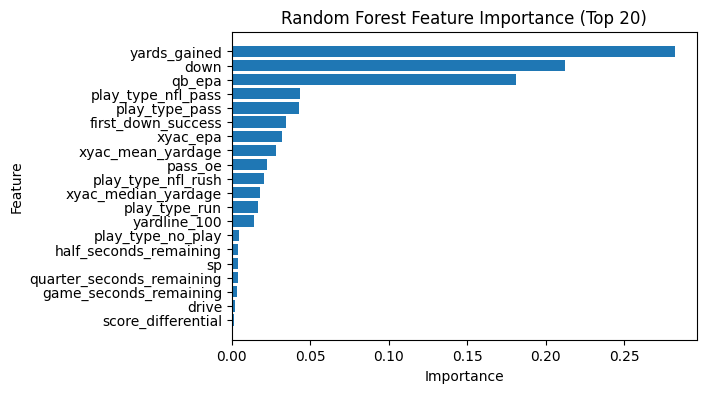

[LightGBM] [Info] Number of positive: 37441, number of negative: 37440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13355
[LightGBM] [Info] Number of data points in the train set: 74881, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500007 -> initscore=0.000027
[LightGBM] [Info] Start training from score 0.000027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

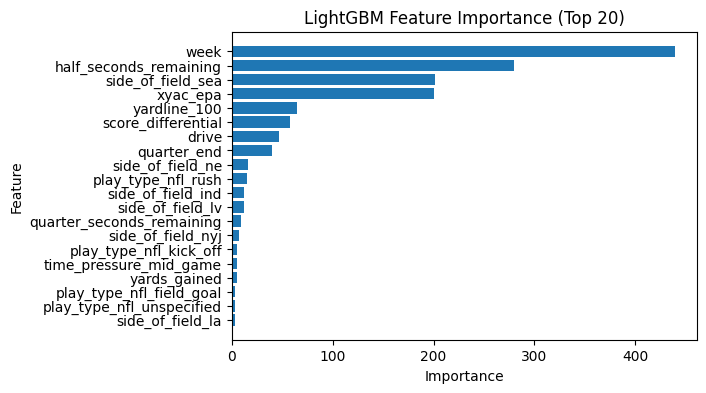

In [19]:
feature_columns = X_test.columns.tolist()
# Define a function for visualizing feature importance in models:
def feature_importance_plot(importances, feature_names, model_name):
    importance_df = pd.DataFrame({"Feature": feature_names, 
                                  "Importance": importances}).sort_values(by="Importance", ascending=False)
    print(f"\nTop 20 Features by Importance for {model_name}:\n")
    print(importance_df.head(20))
    plt.figure(figsize=(6, 4))
    plt.barh(importance_df["Feature"][:20], importance_df["Importance"][:20])
    plt.gca().invert_yaxis()
    plt.title(f"{model_name} Feature Importance (Top 20)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# Feature importance visualization for RF baseline:
rf_model.fit(X_train, y_train)
rf_feature_importances = rf_model.feature_importances_
feature_importance_plot(rf_feature_importances, feature_columns, "Random Forest")

# Feature importance visualization for LightGBM:
lgbm_model.fit(X_train_shuffled, y_train)
lgbm_feature_importances = lgbm_model.feature_importances_
feature_importance_plot(lgbm_feature_importances, feature_columns, "LightGBM")

In [20]:
# Investigating possible overlaps in train-test splits:
train_test_overlap_features = set(X_train.index).intersection(set(X_test.index))
if len(train_test_overlap_features) > 0:
    print(f"WARNING: {len(train_test_overlap_features)} overlapping indices found between X_train and X_test.")
else:
    print("No overlapping indices between X_train and X_test.")

train_test_overlap_target = set(y_train.index).intersection(set(y_test.index))
if len(train_test_overlap_target) > 0:
    print(f"WARNING: {len(train_test_overlap_target)} overlapping indices found between y_train and y_test.")
else:
    print("No overlapping indices between y_train and y_test.")

No overlapping indices between X_train and X_test.
No overlapping indices between y_train and y_test.


Top 20 Features by Mean Absolute SHAP Value:
side_of_field_sea                             7.536999e+00
xyac_epa                                      3.738959e+00
half_seconds_remaining                        6.176413e-15
week                                          4.379293e-15
drive                                         1.061179e-15
score_differential                            6.969678e-16
side_of_field_lv                              5.187039e-16
time_pressure_mid_game                        3.045546e-16
side_of_field_nyj                             2.426500e-16
quarter_end                                   1.652128e-16
side_of_field_la                              1.216524e-16
play_type_nfl_game_start                      1.173433e-16
play_type_nfl_kick_off                        1.148585e-16
yardline_100                                  8.160242e-17
side_of_field_ne                              6.488149e-17
play_type_nfl_fumble_recovered_by_opponent    6.173433e-17
xyac_median

/Users/kavishkartha/Downloads/NFL ML Project/NFL Play Calling Model/venv/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


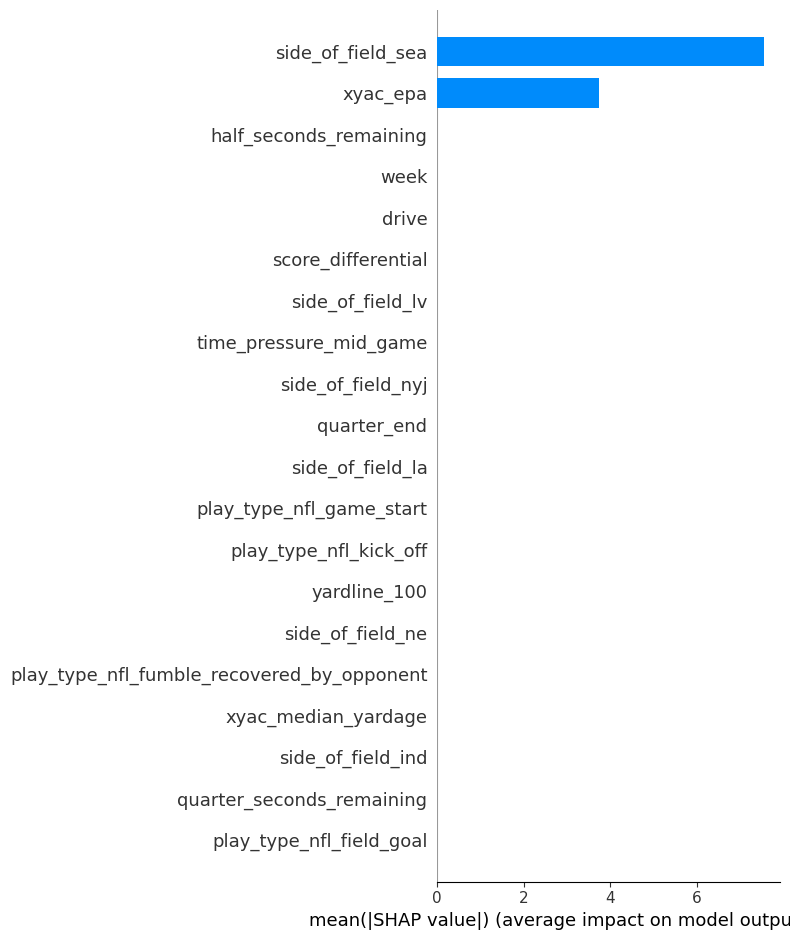

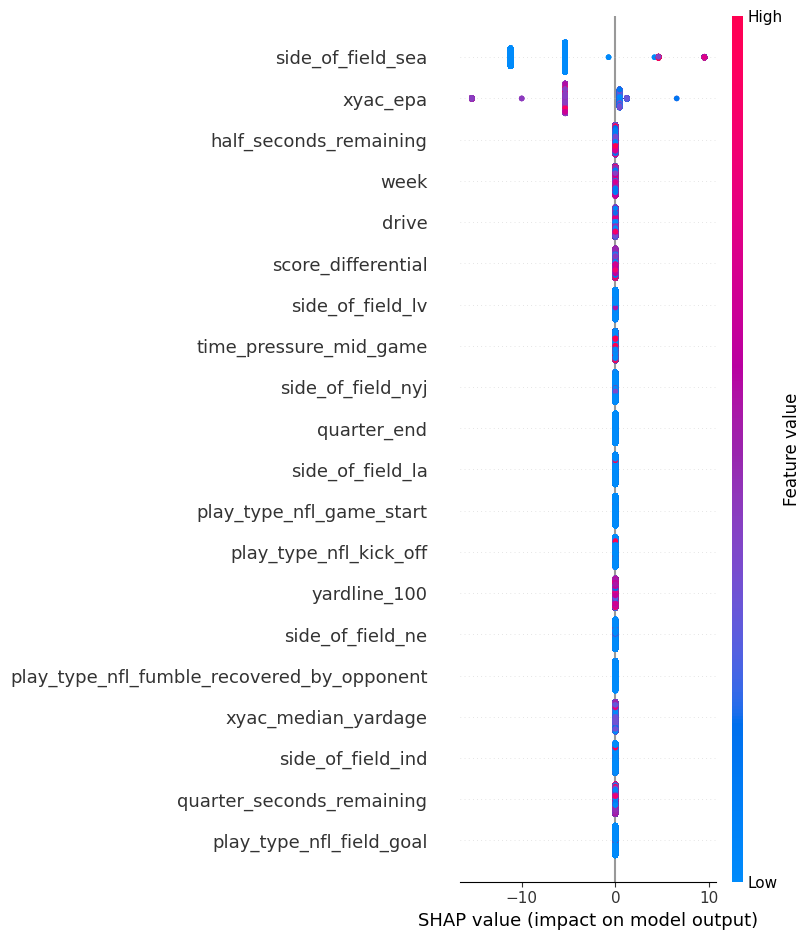

In [21]:
# Initializing SHAP explainer for LightGBM:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test)

# Saving the SHAP values into a DataFrame for better readability:
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

print("Top 20 Features by Mean Absolute SHAP Value:")
print(mean_abs_shap.head(20))
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

Top 20 Features by Permutation Importance:
                  Feature  Importance    StdDev
13               xyac_epa    0.009711  0.000846
70      side_of_field_sea    0.006250  0.000856
0                    week    0.000000  0.000000
49      side_of_field_cle    0.000000  0.000000
55      side_of_field_ind    0.000000  0.000000
54      side_of_field_hou    0.000000  0.000000
53       side_of_field_gb    0.000000  0.000000
52      side_of_field_det    0.000000  0.000000
51      side_of_field_den    0.000000  0.000000
50      side_of_field_dal    0.000000  0.000000
48      side_of_field_cin    0.000000  0.000000
57       side_of_field_kc    0.000000  0.000000
47      side_of_field_chi    0.000000  0.000000
46      side_of_field_car    0.000000  0.000000
45      side_of_field_buf    0.000000  0.000000
44      side_of_field_bal    0.000000  0.000000
43      side_of_field_atl    0.000000  0.000000
42      side_of_field_ari    0.000000  0.000000
41  play_type_nfl_xp_kick    0.000000  0.0000

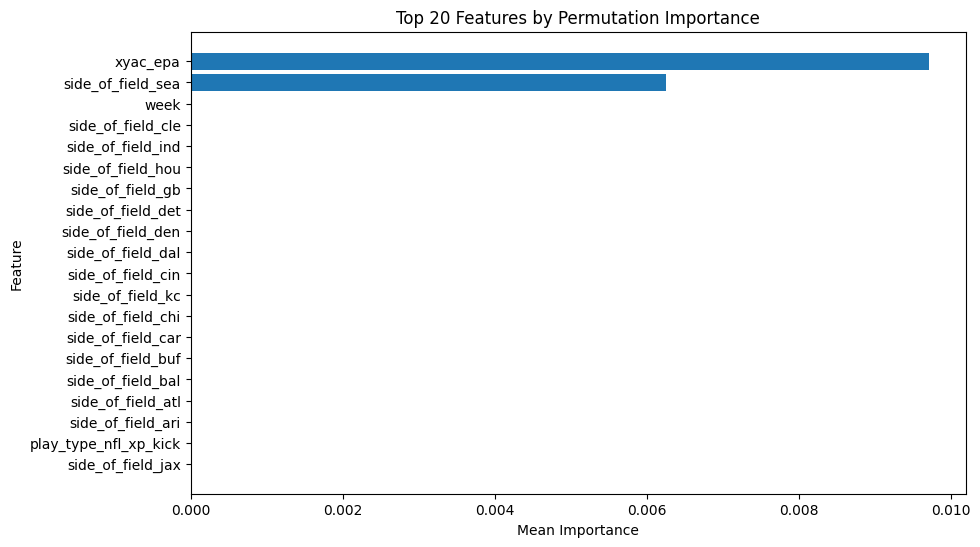

In [22]:
# Measuring permutation importance for LightGBM:
perm_importance = permutation_importance(lgbm_model, X_test, y_test, n_repeats=30, random_state=42)

# Storing the results in a Data Frame for better readability:
perm_importance_df = pd.DataFrame({
    "Feature": feature_columns,
    "Importance": perm_importance.importances_mean,
    "StdDev": perm_importance.importances_std}).sort_values(by="Importance", ascending=False)

print("Top 20 Features by Permutation Importance:")
print(perm_importance_df.head(20))
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df["Feature"].head(20), perm_importance_df["Importance"].head(20))
plt.gca().invert_yaxis()
plt.title("Top 20 Features by Permutation Importance")
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
# Defining a parameter grid for RF baseline model:
rf_parameter_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]}

# Hyperparameter tuning for RF baseline model using randomized search method:
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_parameter_grid,
    n_iter=50,  # Parameter settings sampled
    scoring='f1',  # Evaluating performance using F1 score
    cv=3,  # Number of cross-validation folds
    verbose=2,
    n_jobs=-1,  
    random_state=42)

# Fitting tuned model on training data
rf_random_search.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_random_search.best_params_)
print("Best Random Forest F1 Score:", rf_random_search.best_score_)

In [ ]:
# Defining a parameter grid for LightGBM:
lgbm_parameter_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'min_child_samples': [10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]}

# Hyperparameter tuning for LightGBM using randomized search method:
lgbm_random_search = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_distributions=lgbm_parameter_grid,
    n_iter=50, 
    scoring='f1', 
    cv=3,  
    verbose=2,
    n_jobs=-1,  
    random_state=42)

# Fitting tuned model on training data
lgbm_random_search.fit(X_train, y_train)

print("Best LightGBM Parameters:", lgbm_random_search.best_params_)
print("Best LightGBM F1 Score:", lgbm_random_search.best_score_)

In [ ]:
# Training the RF moel with the most optimal parameters: 
best_rf_params = {
    'n_estimators': 500,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_depth': 20,
    'bootstrap': True}

best_rf_model = RandomForestClassifier(**best_rf_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Evaluating the optimized RF model on test data:
y_rf_pred = best_rf_model.predict(X_test)
y_rf_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

rf_accuracy = accuracy_score(y_test, y_rf_pred)
rf_f1 = f1_score(y_test, y_rf_pred)
rf_roc_auc = roc_auc_score(y_test, y_rf_pred_proba)

print("Best Random Forest Test Set Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print(f"ROC-AUC: {rf_roc_auc:.4f}")

joblib.dump(best_rf_model, '../models/best_random_forest.pkl')
print("Best Random Forest model saved.")

In [ ]:
# Training the LightBGM with the most optimal parameters: 
best_lgbm_params = {
    'subsample': 0.8,
    'num_leaves': 31,
    'n_estimators': 200,
    'min_child_samples': 50,
    'max_depth': 10,
    'learning_rate': 0.05,
    'colsample_bytree': 1.0
}

best_lgbm_model = lgb.LGBMClassifier(**best_lgbm_params, random_state=42)
best_lgbm_model.fit(X_train, y_train)

# Evaluating the optimized LightGBM on test data:
y_lgbm_pred = best_lgbm_model.predict(X_test)
y_lgbm_pred_proba = best_lgbm_model.predict_proba(X_test)[:, 1]

lgbm_accuracy = accuracy_score(y_test, y_lgbm_pred)
lgbm_f1 = f1_score(y_test, y_lgbm_pred)
lgbm_roc_auc = roc_auc_score(y_test, y_lgbm_pred_proba)

print("Best LightGBM Test Set Performance:")
print(f"Accuracy: {lgbm_accuracy:.4f}")
print(f"F1 Score: {lgbm_f1:.4f}")
print(f"ROC-AUC: {lgbm_roc_auc:.4f}")

joblib.dump(best_lgbm_model, '../models/best_lightgbm.pkl')
print("Best LightGBM model saved.")

In [ ]:
# Defining structure for sequential neural network:
def neural_network(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim), # Input layer and 1st hidden layer with 128 neurons and applying ReLU function
        Dropout(0.3), # Preventing overfitting by randomly setting 30% of neurons to 0 value (dropout layers)
        Dense(64, activation='relu'), # 2nd hidden layer with 64 neurons 
        Dropout(0.3),
        Dense(32, activation='relu'), # 3rd hidden layer with 32 neurons
        Dense(1, activation='sigmoid')]) # Single neuron output layer that maps output to a probability value between 0 and 1 
    
    model.compile(optimizer=Adam(learning_rate=0.001), # Using Adam optimization algorithm with learning rate of 0.001
                  loss='binary_crossentropy', # Loss function to calculate difference between predicted probabilities and actual labels
                  metrics=['accuracy']) # Tracking model accuracy during training proccess
    return model

nn_model = neural_network(input_dim=X_train.shape[1])
nn_model.summary()

In [ ]:
# Training the neural network:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # Defining mechanism to stop training proccess early if model performance on validation data is not improving after 5 epochs

history = nn_model.fit(
    X_train, y_train,
    validation_split=0.2, # Reserving 20% of data as hidden data for validation purposes
    epochs=50, # Setting maximum number of epochs to 50
    batch_size=32, # Trains model in batches of 32 samples at a time
    callbacks=[early_stopping], # Calling early_stopping for dynamic control over training proccess 
    verbose=1)

In [ ]:
# Using neural network to make predictions on testing dataset:
y_pred_proba_nn = nn_model.predict(X_test)
y_pred_nn = (y_pred_proba_nn > 0.5).astype(int).squeeze()

# Evaluating accuracy of neural network:
nn_accuracy = accuracy_score(y_test, y_pred_nn)
nn_f1 = f1_score(y_test, y_pred_nn)
nn_roc_auc = roc_auc_score(y_test, y_pred_proba_nn)

print(f"Neural Network Accuracy: {nn_accuracy}")
print(f"Neural Network F1 Score: {nn_f1}")
print(f"Neural Network ROC-AUC: {nn_roc_auc}")

In [ ]:
save_model(nn_model, '../models/nn_model.keras')
print("Neural Network model saved successfully!")

In [ ]:
# Generating predictions from each model:
rf_probs = best_rf_model.predict_proba(X_test)[:, 1]
lgbm_probs = best_lgbm_model.predict_proba(X_test)[:, 1]
nn_probs = nn_model.predict(X_test).flatten()

print(f"Random Forest Predictions Shape: {rf_probs.shape}")
print(f"LightGBM Predictions Shape: {lgbm_probs.shape}")
print(f"Neural Network Predictions Shape: {nn_probs.shape}")

In [ ]:
# Defining weights for each of the predictions:
rf_weight = 1 / 3
lgbm_weight = 1 / 3
nn_weight = 1 / 3

# Calculating the combined weighted average for the optimized predictions:
ensemble_probs = (
    rf_weight * rf_probs +
    lgbm_weight * lgbm_probs +
    nn_weight * nn_probs)

ensemble_predictions = (ensemble_probs >= 0.5).astype(int)

print("Sample Ensemble Predictions (Probabilities):", ensemble_probs[:5])
print("Sample Ensemble Predictions (Binary):", ensemble_predictions[:5])

In [ ]:
# Evaluating esnemble model predictions:
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_f1 = f1_score(y_test, ensemble_predictions)
ensemble_roc_auc = roc_auc_score(y_test, ensemble_probs)

print("Ensemble Model Performance:")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print(f"F1 Score: {ensemble_f1:.4f}")
print(f"ROC-AUC: {ensemble_roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, ensemble_predictions))

In [ ]:
feature_medians = data.median()
feature_medians.to_csv('../data/processed/feature_medians.csv', header=True)
print(feature_medians)

In [ ]:
for col in data.columns:
    print(col)

In [ ]:
feature_medians = data.median()
feature_medians.to_csv("../data/processed/feature_medians.csv")